
# Purpose of Notebook

The goal of this code is to investigate deep mixing with Red Giants.
- The mass used will be generated using a Random Forest Model

The steps that will need to be taken in order to investigate deep mixing
1.  Compute Carbon to Nitrogen Ratio for Red Giants $$ \Big[\frac{C}{N}\Big] = \Big[\frac{C}{Fe}\Big] - \Big[\frac{N}{Fe}\Big] $$
2.  Determine which stars are Red Giants
    - To achieve this, we will need to graph `log(g)` vs `teff` to create a HR diagram
    - Using the HR diagram, we will then determine the Red Giants

3.  Separate Stars into _**need help with this**_

## Expected Results
We should see the deep mixing decreases as a function of mass and metallicity.
- Which of the two factors are more significant remains to be seen.

In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn.linear_model import LinearRegression
from statistics import mean

In [94]:
apogee = pd.read_csv("ProcessedData/apogee_with_mass.csv")

# 1. Compute Relative Abundance of Carbon to Nitrogen

In [95]:
apogee["c_n"] = apogee.c_fe - apogee.n_fe
apogee.columns

Index(['tmass_id', 'teff', 'logg', 'fe_h', 'alpha_m', 'c_fe', 'n_fe', 'o_fe',
       'ra', 'dec', 'rv_chi2', 'gaiaedr3_pmra', 'gaiaedr3_pmdec', 'mass',
       'c_n'],
      dtype='object')

In [4]:
apogee.c_n

0        -0.141925
1        -0.766240
2        -0.109907
3        -0.312257
4        -0.526230
            ...   
419051   -0.057909
419052   -0.188439
419053   -0.344606
419054   -0.262194
419055   -0.220958
Name: c_n, Length: 419056, dtype: float64

# 2. Find the !(Blue Midgets)

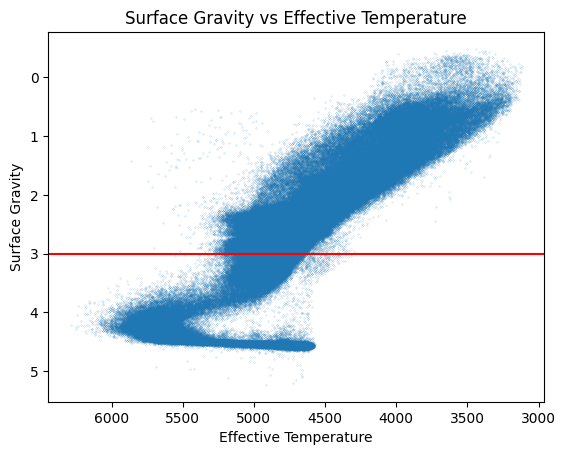

In [96]:
figure = plt.plot(
    apogee.teff,
    apogee.logg,
    '.',
    markersize=0.2,
)

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.xlabel("Effective Temperature")
plt.ylabel("Surface Gravity")
plt.title("Surface Gravity vs Effective Temperature")
# The Cutoff is round
plt.axhline(y=3, color='r', linestyle='-')

Text(0.5, 1.0, 'Surface Gravity vs Log Effective Temperature')

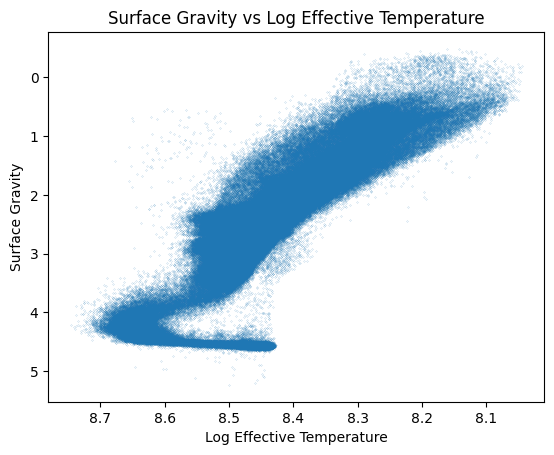

In [6]:
plt.plot(
    np.log(apogee.teff),
    apogee.logg,
    '.',
    markersize=0.2,
)
plt.plot()

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.xlabel("Log Effective Temperature")
plt.ylabel("Surface Gravity")
plt.title("Surface Gravity vs Log Effective Temperature")
# No significant difference so this will be ignored.

Based on the analysis above, the ideal cutoff for red giants is for `log g > 3.5`.

In [100]:
red_giants_apogee = apogee.query("logg < 3")
red_giants_apogee.to_csv("ProcessedData/apogee_red_giant.csv", index=False)

In [5]:
red_giants_apogee = pd.read_csv("ProcessedData/apogee_red_giant.csv")

# 3. Investigate Deep Mixing as a function of Mass and Metallicity.


Separate Data into 25 Groups, which is determined by the metallicity and mass.
- Separate Mass like so:
$$ 0.5 \leq \frac{M}{M_\odot} < 1 , 1 \leq \frac{M}{M_\odot} < 1.25,  1.25 \leq \frac{M}{M_\odot} < 1.50, 1.50 \leq \frac{M}{M_\odot} < 2.2 ,\frac{M}{M_\odot} \geq 2.2 $$

- Separate Metallicity like so:
$$ 0.25 \geq \Big[\frac{Fe}{H}\Big] > -0.25$, -0.25 \geq \Big[\frac{Fe}{H}\Big] > -0.75$, -0.75 \geq \Big[\frac{Fe}{H}\Big] > -1.25$, -1.25 \geq \Big[\frac{Fe}{H}\Big] > -1.75$, -1.75 \geq \Big[\frac{Fe}{H}\Big] > -4 $$


In [98]:
fe_h_range = [0.25, -0.25, -0.75, -1.25, -1.75, -4]
mass_range = [0.5, 1, 1.25, 1.5, 2.2, 4.0]
# Approximate position of RGBb
rgbbedge = [[2.666, 2.661, 2.654, 2.587, 2.50],
            [2.509, 2.500, 2.432, 2.456, 2.4],
            [2.301, 2.277, 2.222, 2.186, 2.1],
            [2.106, 2.060, 2.036, 2.098, 2.0],
            [1.953, 1.895, 1.881, 1.846, 1.8]]

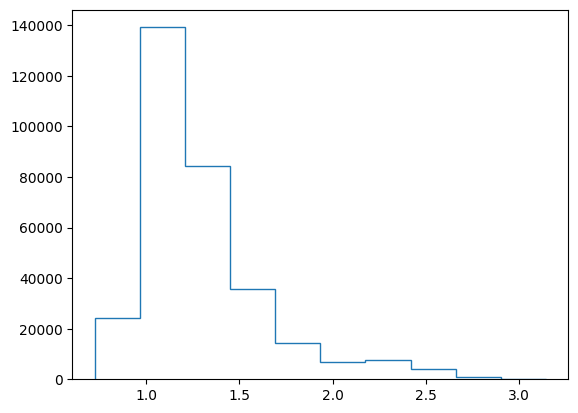

In [11]:
red_giants_apogee.mass.describe()
counts, bins = np.histogram(red_giants_apogee.mass)
plt.stairs(counts, bins)

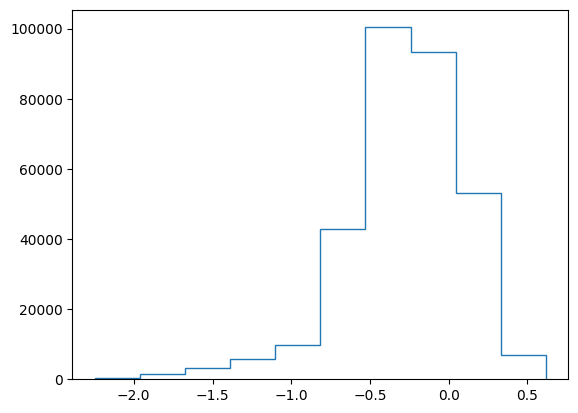

In [12]:
red_giants_apogee.fe_h.describe()
counts, bins = np.histogram(red_giants_apogee.fe_h)
plt.stairs(counts, bins)

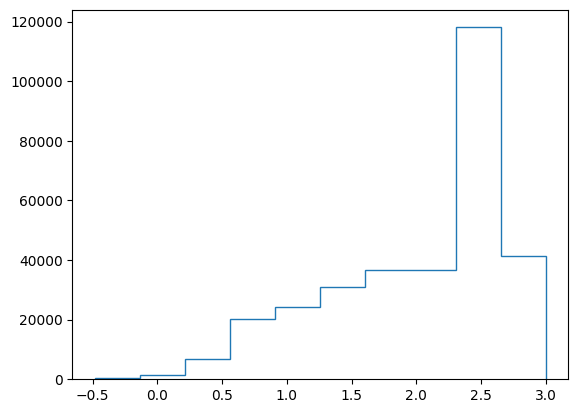

In [13]:
red_giants_apogee.logg.describe()
counts, bins = np.histogram(red_giants_apogee.logg)
plt.stairs(counts, bins)

TypeError: cannot unpack non-iterable PathCollection object

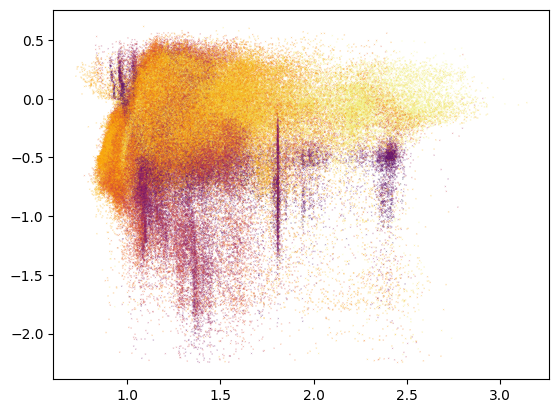

In [147]:
fig, ax = plt.scatter(red_giants_apogee.mass, red_giants_apogee.fe_h, marker='x', linewidths=0.1,
                      c=red_giants_apogee.logg, cmap=plt.cm.inferno, s=1)
plt.xlabel("$M_{pred} (M_\odot)$")
plt.ylabel("[$Fe/H$]")

Now that we have gotten the data, we can begin to look at deep mixing present in each stars.

In [167]:
deep_mixing_measurement = pd.DataFrame(columns=["gradient", "avg_mass", "avg_fe_h"])

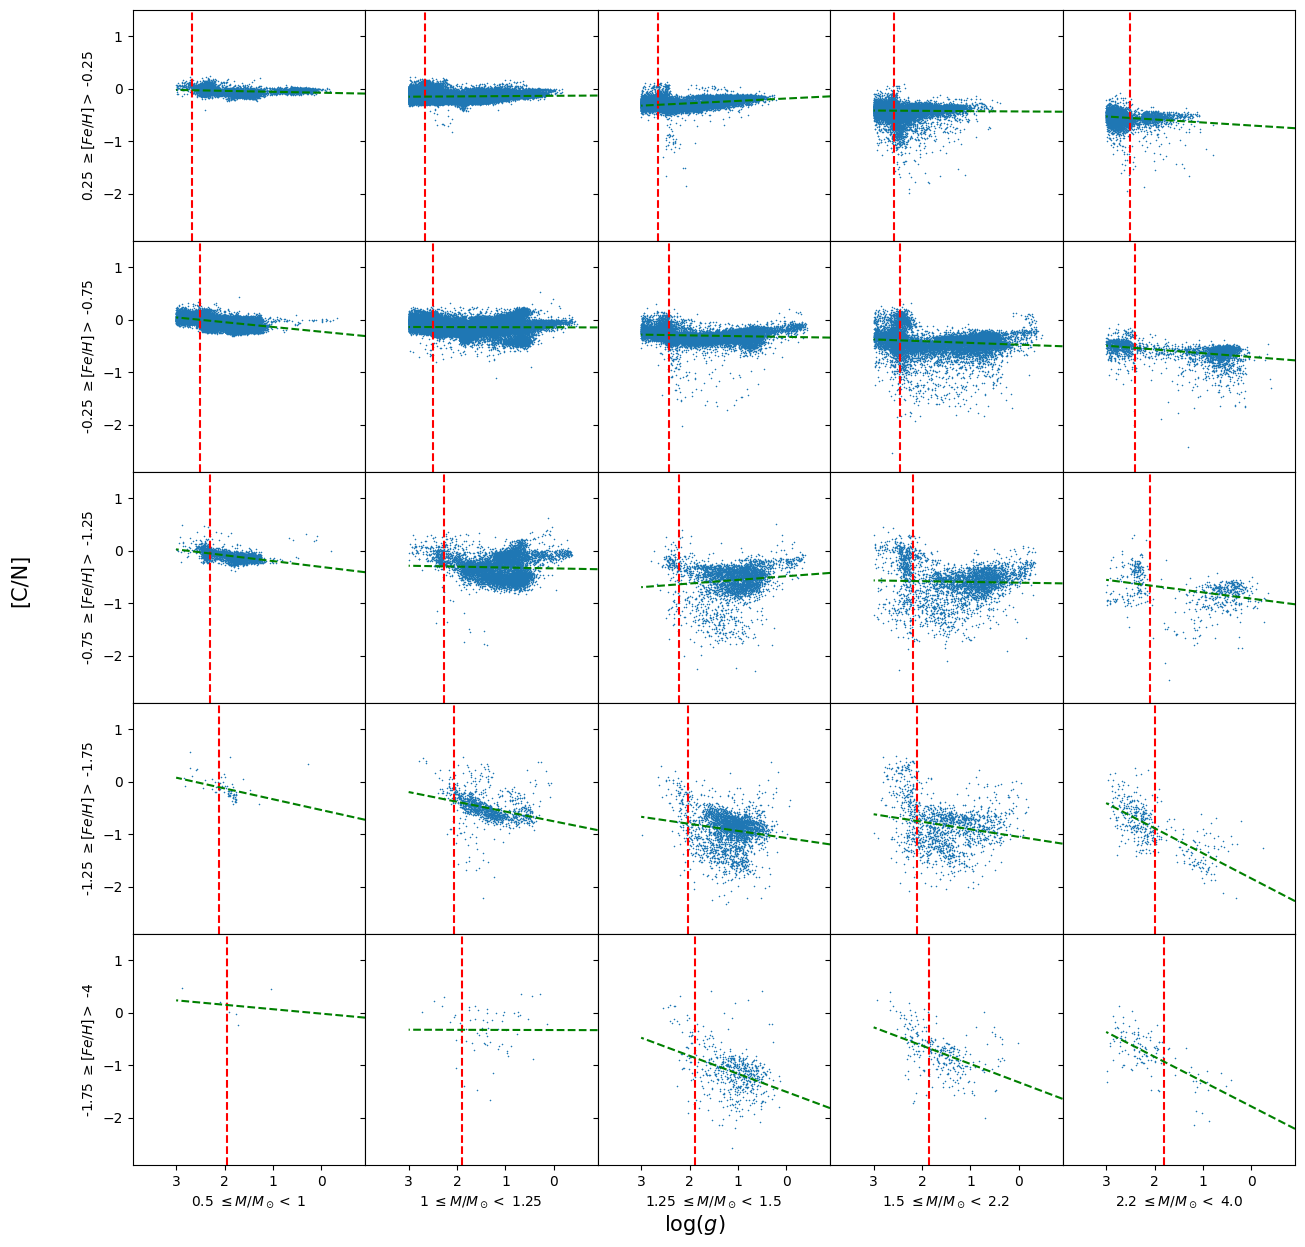

In [168]:
figure, axis = plt.subplots(
    nrows=5,
    ncols=5,
    figsize=(15, 15),
    sharex=True,
    sharey=True
)

figure.subplots_adjust(hspace=0)
figure.subplots_adjust(wspace=0)
figure.text(0.5, 0.07, "$\log(g)$", ha="center", va="center", fontsize=15)
figure.text(0.05, 0.5, "[C/N]", ha="center", va="center", rotation="vertical",fontsize=15)
plt.axis([3.9, -0.9, -2.9, 1.5])

index = 0
# Populate each part of the graph
for i in range(0, 5): # Iterate over metallicity
    for j in range(0, 5): # Iterate over mass
        bin = red_giants_apogee[
            (red_giants_apogee.mass >= mass_range[j]) & (red_giants_apogee.mass < mass_range[j + 1]) & (red_giants_apogee.fe_h <= fe_h_range[i]) & (red_giants_apogee.fe_h > fe_h_range[i + 1])
        ]
        # Labels
        axis[i, j].set_xlabel(f"{mass_range[j]} $\leq M/M_\odot <$ {mass_range[j+1]}")
        if (j == 0):
            axis[i, j].set_ylabel(f"{fe_h_range[i]} $\geq [Fe/H] >$ {fe_h_range[i+1]}")
        # Plot the data and where deep mixing should occur
        axis[i, j].plot(bin.logg, bin.c_n,"x", markersize=.5)
        axis[i, j].axvline(x=rgbbedge[i][j], color='r', linestyle='--')
        # Find the Polynomial Function that tracks change in C/N
        poly_model = LinearRegression()
        poly_model.fit(
            np.array(bin.logg).reshape((-1, 1)),
            np.array(bin.c_n)
        )
        X = np.arange(-1, 3, 0.001).reshape((-1, 1))
        y = poly_model.predict(X)
        axis[i, j].plot(X, y, "--", markersize=.5, color='g')
        # Compute the gradient
        y_gradient = poly_model.predict(np.array([0, 1]).reshape((-1, 1)))
        gradient = y_gradient[0] - y_gradient[1]
        avg_mass = mean(bin.mass)
        avg_fe_h = mean(bin.fe_h)
        deep_mixing_measurement.loc[index] = [gradient, avg_mass, avg_fe_h]
        index = index + 1


We make the gradient $\frac{d[C/N]}{d log(g)}$ for each bin.

- For each bin, we also calculated the average mass and metallicity.

 Now we determine the strength of each parameter

In [169]:
deep_mixing_measurement

,gradient,avg_mass,avg_fe_h
0,-0.017902,0.958915,-0.110251
1,0.005631,1.123025,-0.027944
2,0.045391,1.363886,-0.040153
3,-0.005756,1.722148,-0.022596
4,-0.057393,2.427395,-0.034823
5,-0.090873,0.951944,-0.474029
6,-0.002109,1.101558,-0.446682
7,-0.014440,1.356793,-0.428048
8,-0.033538,1.721424,-0.457551
9,-0.071609,2.374336,-0.450468


Text(0, 0.5, 'd[C/N]/dlog(g)')

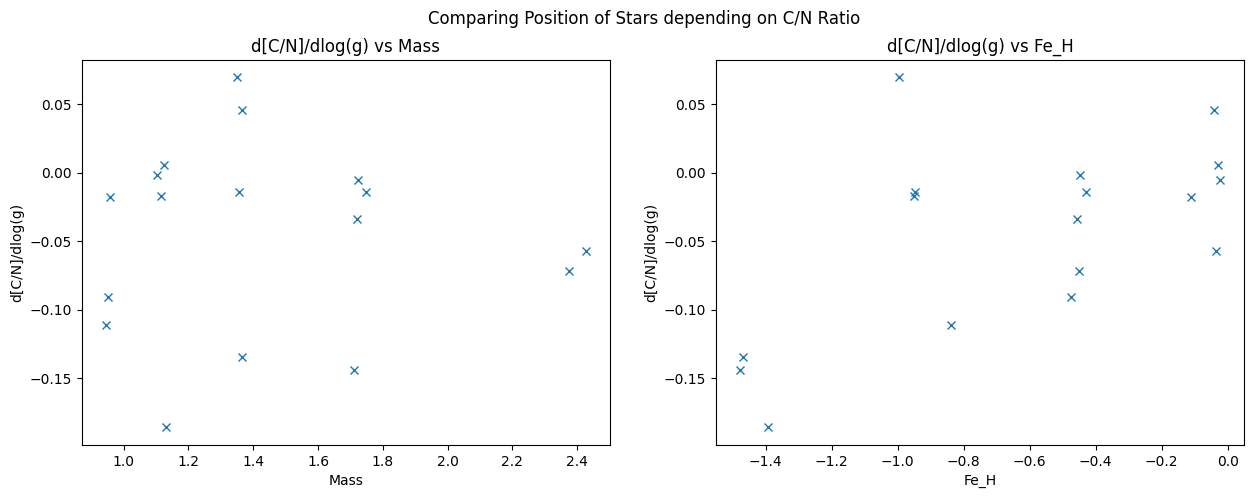

In [170]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

figure.suptitle("Comparing Position of Stars depending on C/N Ratio")
ax1.plot(deep_mixing_measurement.avg_mass, deep_mixing_measurement.gradient, 'x')
ax1.set_title("d[C/N]/dlog(g) vs Mass")
ax1.set_xlabel("Mass")
ax1.set_ylabel("d[C/N]/dlog(g)")

ax2.plot(deep_mixing_measurement.avg_fe_h, deep_mixing_measurement.gradient, 'x')
ax2.set_title("d[C/N]/dlog(g) vs Fe_H")
ax2.set_xlabel("Fe_H")
ax2.set_ylabel("d[C/N]/dlog(g)")


## Additional Research: Investigating the dip
Notice that for all graphs, we can observe that there is a main group where most of the stars resides.
However, for some, some stars seem to fall under the main grouping (since the scale is logarithmic, this means the ratio between carbon to nitrogen is lower than 10 times for some data points!)

For this low $\Big[\frac{C}{N}\Big]$ stars, one potential answer is they may be either a part of a globular cluster and thus start out with lower relative abundances or AGB (asymptotic giant branch) stars.


### Globular Clusters

Text(0.5, 1.0, '$[C/N]$ vs Surface Gravity')

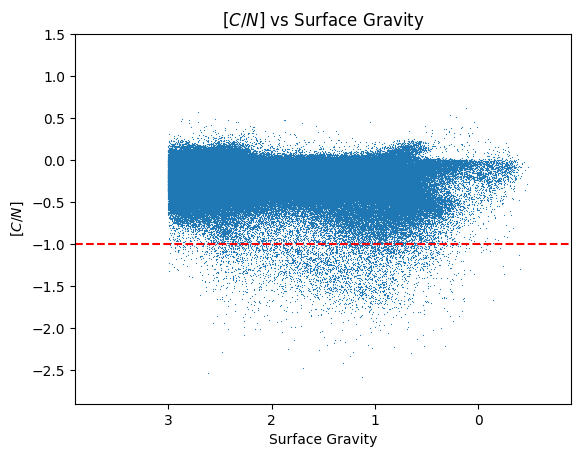

In [59]:
plt.plot(red_giants_apogee.logg, red_giants_apogee.c_n, 'x', markersize=0.2)
plt.axhline(-1, color='r', linestyle='--')
plt.axis([3.9, -0.9, -2.9, 1.5])
plt.xlabel("Surface Gravity")
plt.ylabel("$[C/N]$")
plt.title("$[C/N]$ vs Surface Gravity")

From the graph above, we can see that majority of stars have a carbon to nitrogen abundance greater than -1.

In [68]:
gc = red_giants_apogee.query("c_n < -1")

From here, to determine whether they are in fact from globular clusters, we can assess:
- Position
- Radial Velocity
- Proper Motion

We expect the data to form groups if they are in clusters.

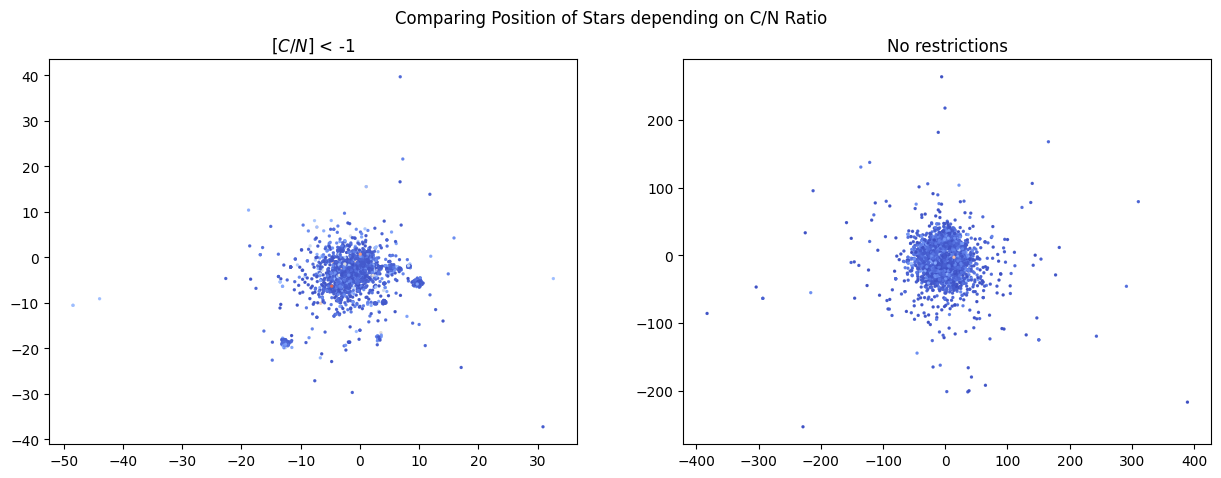

In [80]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

figure.suptitle("Comparing Position of Stars depending on C/N Ratio")
ax1.scatter(gc.gaiaedr3_pmra, gc.gaiaedr3_pmdec, marker='o', linewidth=0.1, c=gc.rv_chi2, s=5, cmap=plt.cm.coolwarm)
# fig, ax = plt.scatter(red_giants_apogee.mass, red_giants_apogee.fe_h, marker='x', linewidths=0.1, c=red_giants_apogee.logg, cmap=plt.cm.viridis, s=1)
# ax1.xlabel("PMRA")
# ax1.ylabel("PMDEC")
ax1.set_title("$[C/N]$ < -1")

ax2.set_title("No restrictions")
ax2.scatter(red_giants_apogee.gaiaedr3_pmra, red_giants_apogee.gaiaedr3_pmdec, marker='o', linewidth=0.1, c=red_giants_apogee.rv_chi2, s=5, cmap=plt.cm.coolwarm)

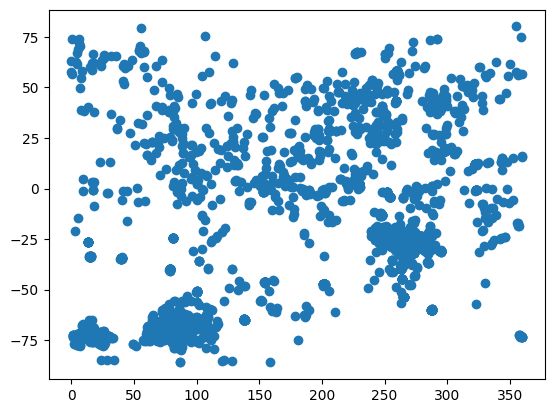

In [107]:
plt.scatter(gc.ra, gc.dec)

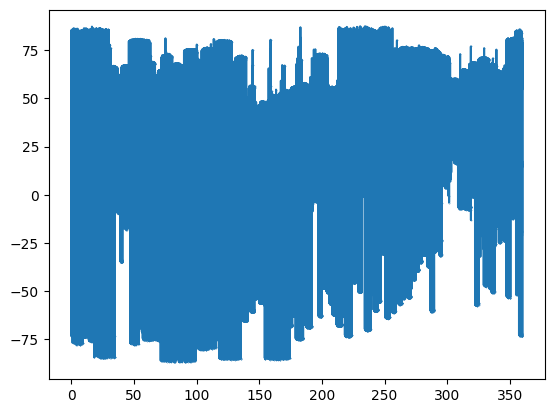

In [112]:
plt.plot(red_giants_apogee.ra, red_giants_apogee.dec, markersize=0.2, marker='o')

Given the must tighter spread of positions (notice that the stars with a C/N ratio less than -1 have bounds between 50 and -50 while the one with no restriction is between 400 to -400 approximately.

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff64a0a5ca0>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff64a0d12b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff64a0a59d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff64a0d1850>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff64a0d1b20>],
 'means': []}

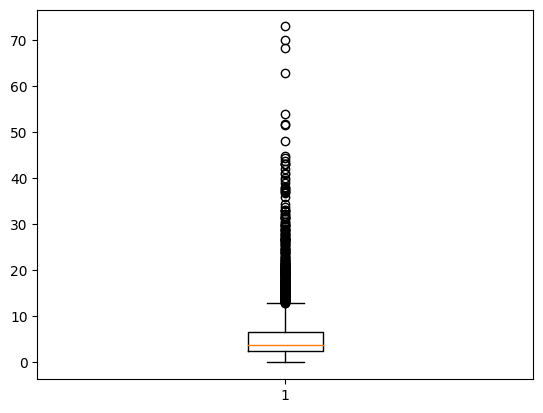

In [67]:
plt.boxplot(gc.rv_chi2)

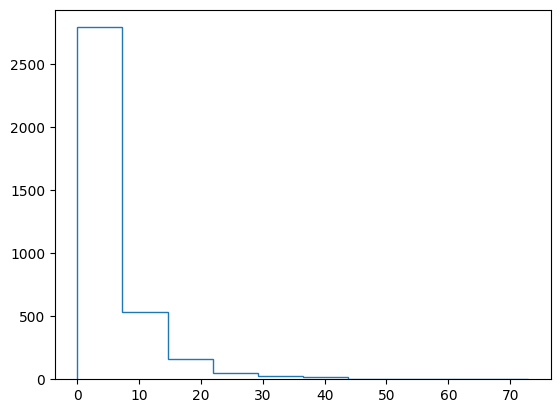

In [89]:
plt.hist(gc.rv_chi2)

(6000.0, 3000.0, 3.2, -0.5)

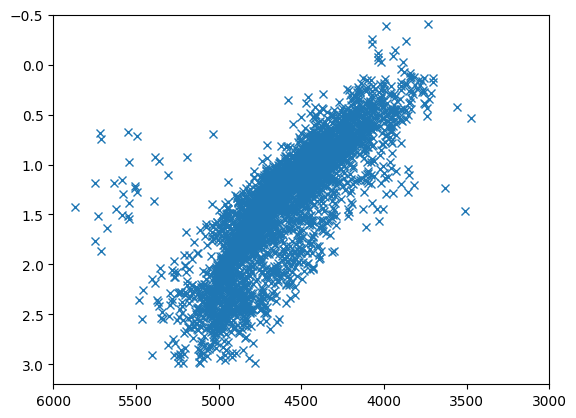

In [113]:
plt.plot(gc.teff, gc.logg, "x")
plt.axis([6000, 3000, 3.2, -0.5])

It seems that most stars are red giants.
- The group on the left are likely stars on the main sequence that were not filtered out due to having low `log g` despite being main sequence stars.